# Task 2 — Exploratory Data Analysis (EDA)
- Outputs: data/processed/task2_eda_outputs/ (CSVs + PNG plots)

In [1]:

from __future__ import annotations

import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from typing import cast

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 130
warnings.filterwarnings("ignore")

In [2]:

def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start, *start.parents]:
        if (p / "src").exists() and (p / "data").exists():
            return p
    raise FileNotFoundError(
        "Could not find project root (expected folders: 'src' and 'data'). "
        f"Started from: {start}"
    )

ROOT = find_project_root()
DATA_PATH = ROOT / "data" / "processed" / "ethiopia_fi_unified_data__enriched.csv"
OUT_DIR = ROOT / "data" / "processed" / "task2_eda_outputs"
PLOT_DIR = OUT_DIR / "plots"
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("DATA_PATH:", DATA_PATH)
print("OUT_DIR:", OUT_DIR)

ROOT: D:\Python\Week10\Forecasting-Financial-Inclusion-in-Ethiopia
DATA_PATH: D:\Python\Week10\Forecasting-Financial-Inclusion-in-Ethiopia\data\processed\ethiopia_fi_unified_data__enriched.csv
OUT_DIR: D:\Python\Week10\Forecasting-Financial-Inclusion-in-Ethiopia\data\processed\task2_eda_outputs


In [3]:

assert DATA_PATH.exists(), f"Missing dataset: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
print("rows:", len(df), "cols:", df.shape[1])
df.head(3)

rows: 43 cols: 35


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,parent_id
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,...,NaN,NaN,NaN,NaN,Example_Trainee,1/20/2025,NaN,Baseline year,NaN,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,...,NaN,NaN,NaN,NaN,Example_Trainee,1/20/2025,NaN,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,...,NaN,NaN,NaN,NaN,Example_Trainee,1/20/2025,NaN,NaN,NaN,NaN


In [4]:

required_cols = [
    "record_id","record_type","pillar","indicator","indicator_code","value_numeric",
    "observation_date","source_type","confidence","gender","location",
]
missing = [c for c in required_cols if c not in df.columns]
assert not missing, f"Dataset missing required columns: {missing}"

for c in ["record_type","pillar","source_type","confidence","gender","location","indicator_code"]:
    df[c] = df[c].astype(str).str.strip().str.lower()

# Parse observation_date first; keep a typed local Series so Pylance knows .dt.year exists
obs_dt = pd.to_datetime(df["observation_date"], errors="coerce")
df["observation_date"] = obs_dt

if df["value_numeric"].dtype == object:
    df["value_numeric"] = pd.to_numeric(df["value_numeric"], errors="coerce")

# Use nullable integer year (handles NaT)
df["year"] = obs_dt.dt.year.astype("Int64")

print(df["record_type"].value_counts(dropna=False))

record_type
observation    30
event          10
target          3
Name: count, dtype: int64


## 1) Dataset Overview


In [5]:

summary_record_type = df["record_type"].value_counts(dropna=False).rename_axis("record_type").reset_index(name="n")
summary_pillar = df["pillar"].replace({"nan": np.nan, "none": np.nan, "": np.nan}).value_counts(dropna=False).rename_axis("pillar").reset_index(name="n")
summary_source_type = df["source_type"].value_counts(dropna=False).rename_axis("source_type").reset_index(name="n")

summary_record_type.to_csv(OUT_DIR / "summary_by_record_type.csv", index=False)
summary_pillar.to_csv(OUT_DIR / "summary_by_pillar.csv", index=False)
summary_source_type.to_csv(OUT_DIR / "summary_by_source_type.csv", index=False)

summary_record_type, summary_pillar, summary_source_type


(   record_type   n
 0  observation  30
 1        event  10
 2       target   3,
           pillar   n
 0         access  16
 1          usage  11
 2            NaN  10
 3         gender   5
 4  affordability   1,
   source_type   n
 0    operator  15
 1      survey  10
 2   regulator   7
 3    research   4
 4      policy   3
 5  calculated   2
 6        news   2)

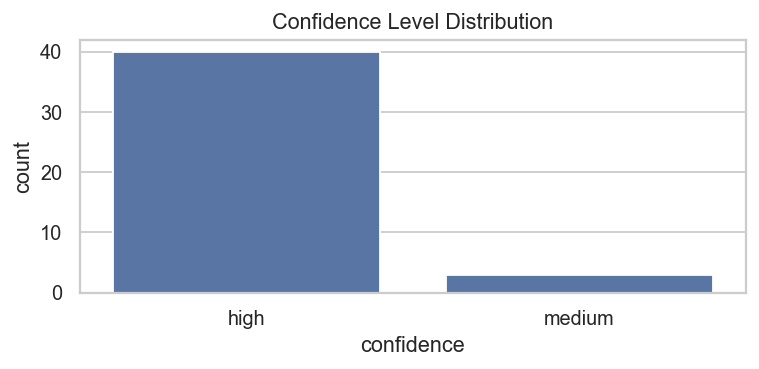

In [6]:

conf = df["confidence"].value_counts(dropna=False).rename_axis("confidence").reset_index(name="n")
conf.to_csv(OUT_DIR / "confidence_distribution.csv", index=False)

plt.figure(figsize=(6,3))
ax = sns.barplot(data=conf, x="confidence", y="n", color="#4C72B0")
ax.set_title("Confidence Level Distribution")
ax.set_xlabel("confidence")
ax.set_ylabel("count")
plt.tight_layout()
plt.savefig(PLOT_DIR / "confidence_distribution.png")
plt.show()

In [7]:

obs = df[df["record_type"] == "observation"].copy()

indicator_counts = (
    obs.groupby(["indicator_code","indicator"], dropna=False)
       .agg(n_obs=("value_numeric","count"), min_date=("observation_date","min"), max_date=("observation_date","max"))
       .reset_index()
       .sort_values(["n_obs","indicator_code"], ascending=[True, True])
)
indicator_counts.to_csv(OUT_DIR / "indicator_coverage_from_data.csv", index=False)

sparse_le2 = indicator_counts[indicator_counts["n_obs"] <= 2].copy()
snapshot_eq1 = indicator_counts[indicator_counts["n_obs"] == 1].copy()
sparse_le2.to_csv(OUT_DIR / "sparse_indicators_nobs_le2.csv", index=False)
snapshot_eq1.to_csv(OUT_DIR / "snapshot_only_indicators_nobs_eq1.csv", index=False)

indicator_counts.head(10)

,indicator_code,indicator,n_obs,min_date,max_date
3,acc_mobile_pen,Mobile Subscription Penetration,1,2025-12-31,2025-12-31
5,aff_data_income,Data Affordability Index,1,2024-12-31,2024-12-31
7,gen_gap_mobile,Mobile Phone Gender Gap,1,2024-12-31,2024-12-31
8,gen_mm_share,Female Mobile Money Account Share,1,2024-12-31,2024-12-31
9,usg_active_rate,Mobile Money Activity Rate,1,2024-12-31,2024-12-31
10,usg_atm_count,ATM Transaction Count,1,2025-07-07,2025-07-07
11,usg_atm_value,ATM Transaction Value,1,2025-07-07,2025-07-07
12,usg_crossover,P2P/ATM Crossover Ratio,1,2025-07-07,2025-07-07
13,usg_mpesa_active,M-Pesa 90-Day Active Users,1,2024-12-31,2024-12-31
14,usg_mpesa_users,M-Pesa Registered Users,1,2024-12-31,2024-12-31


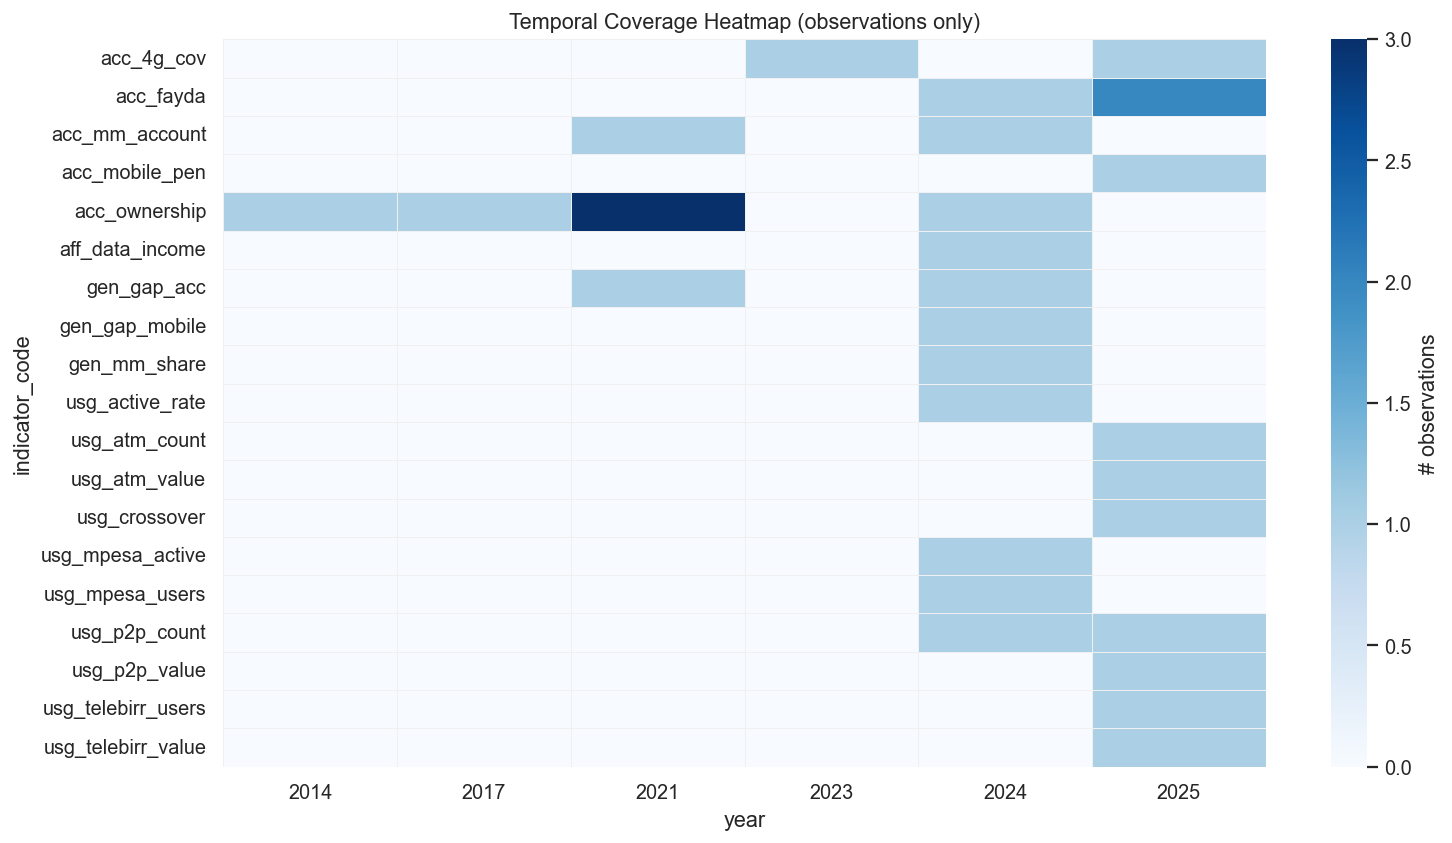

In [8]:

coverage = (
    obs.dropna(subset=["year","indicator_code"])
       .groupby(["indicator_code","year"]).size()
       .reset_index(name="n")
)
piv = coverage.pivot(index="indicator_code", columns="year", values="n").fillna(0).astype(int)
piv.to_csv(OUT_DIR / "temporal_coverage_heatmap_matrix.csv")

plt.figure(figsize=(12, max(3, 0.35*len(piv))))
ax = sns.heatmap(piv, cmap="Blues", linewidths=0.5, linecolor="#f0f0f0", cbar_kws={"label":"# observations"})
ax.set_title("Temporal Coverage Heatmap (observations only)")
ax.set_xlabel("year")
ax.set_ylabel("indicator_code")
plt.tight_layout()
plt.savefig(PLOT_DIR / "temporal_coverage_heatmap.png")
plt.show()


## 2) Access Analysis

In [9]:

ACC_OWN = "acc_ownership"
acc_all = obs[(obs["indicator_code"] == ACC_OWN) & (obs["gender"] == "all") & (obs["location"] == "national")].copy()
acc_all = acc_all.dropna(subset=["year","value_numeric"]).sort_values("year")
acc_all[["year","value_numeric","source_name","confidence"]]

,year,value_numeric,source_name,confidence
0,2014,22.0,Global Findex 2014,high
1,2017,35.0,Global Findex 2017,high
2,2021,46.0,Global Findex 2021,high
5,2024,49.0,Global Findex 2024,high


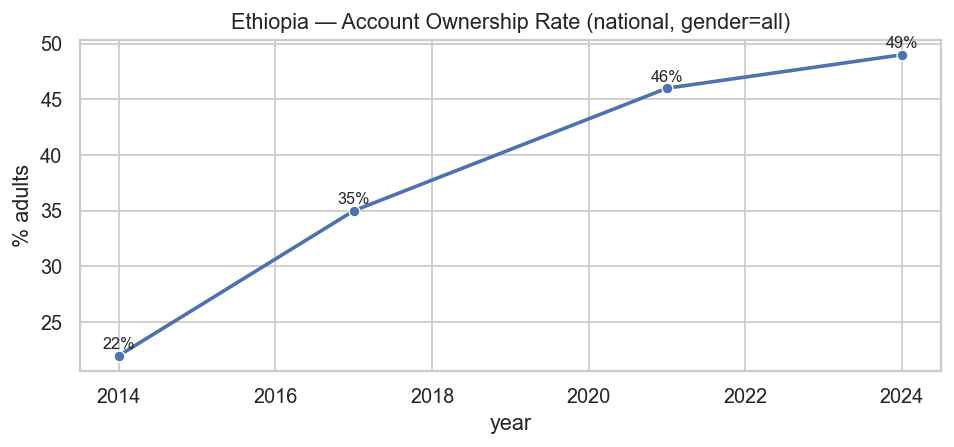

In [10]:

plt.figure(figsize=(7.5,3.6))
ax = sns.lineplot(data=acc_all, x="year", y="value_numeric", marker="o", linewidth=2)
ax.set_title("Ethiopia — Account Ownership Rate (national, gender=all)")
ax.set_xlabel("year")
ax.set_ylabel("% adults")
for _, r in acc_all.iterrows():
    ax.text(r["year"], r["value_numeric"]+0.6, f"{r['value_numeric']:.0f}%", ha="center", fontsize=9)
plt.tight_layout()
plt.savefig(PLOT_DIR / "access_account_ownership_trajectory.png")
plt.show()

In [11]:

acc_all2 = acc_all[["year", "value_numeric"]].drop_duplicates().sort_values("year").copy()
acc_all2["pp_change"] = acc_all2["value_numeric"].diff()

# prev_year as nullable int
acc_all2["prev_year"] = acc_all2["year"].shift(1).astype("Int64")

y0 = acc_all2["prev_year"]
y1 = acc_all2["year"].astype("Int64")

# Build period labels WITHOUT pandas Series.where (avoids Pylance "other" type errors)
labels = y0.astype(str) + "→" + y1.astype(str)
acc_all2["period"] = pd.Series(np.where(y0.notna(), labels, np.nan), index=acc_all2.index).astype("string")

growth = acc_all2.dropna(subset=["pp_change"])[["period", "pp_change"]].copy()
growth.to_csv(OUT_DIR / "acc_ownership_growth_pp_by_period.csv", index=False)
growth

,period,pp_change
1,2014→2017,13.0
2,2017→2021,11.0
5,2021→2024,3.0


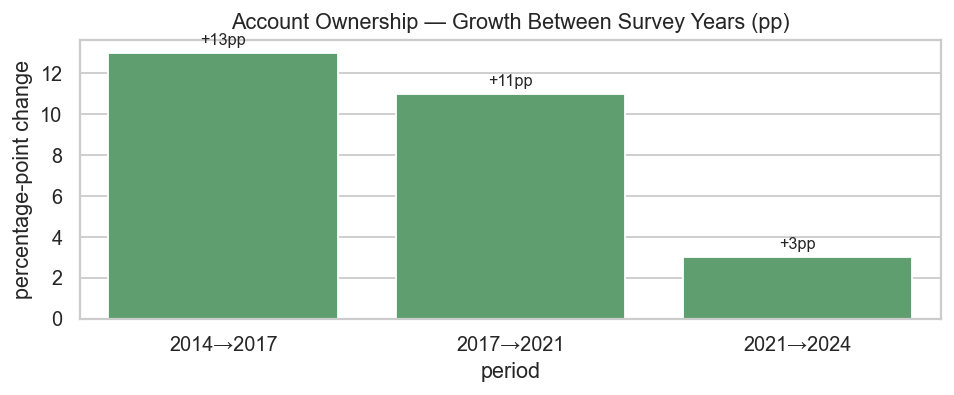

In [12]:
plt.figure(figsize=(7.5,3.2))
ax = sns.barplot(data=growth, x="period", y="pp_change", color="#55A868")
ax.axhline(0, color="black", linewidth=1)
ax.set_title("Account Ownership — Growth Between Survey Years (pp)")
ax.set_xlabel("period")
ax.set_ylabel("percentage-point change")
#for i, r in growth.reset_index(drop=True).iterrows():
#    ax.text(i, r.pp_change + (0.4 if r.pp_change>=0 else -0.8), f"{r.pp_change:+.0f}pp", ha="center", fontsize=9)

growth["pp_change"] = pd.to_numeric(growth["pp_change"], errors="coerce").astype("float64")

for i, row in enumerate(growth.itertuples(index=False), start=0):
    y = float(cast(float, row.pp_change))
    if np.isnan(y):
        continue

    ax.text(
        float(i),
        y + (0.4 if y >= 0 else -0.8),
        f"{y:+.0f}pp",
        ha="center",
        fontsize=9,
    )
plt.tight_layout()
plt.savefig(PLOT_DIR / "access_account_ownership_growth_pp.png")
plt.show()

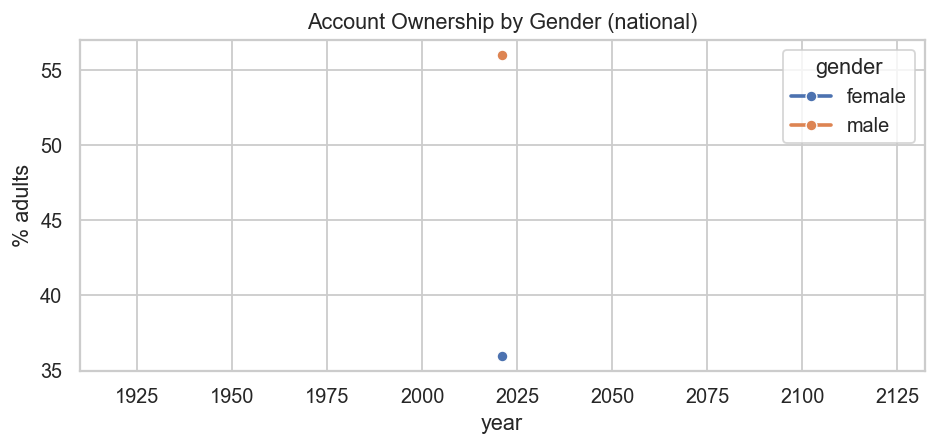

gender,year,female,male,gap_male_minus_female_pp
0,2021,36.0,56.0,20.0


In [13]:

acc_gender = obs[(obs["indicator_code"] == ACC_OWN) & (obs["gender"].isin(["male","female"])) & (obs["location"] == "national")].copy()
acc_gender = acc_gender.dropna(subset=["year","value_numeric"]).sort_values(["year","gender"])

if len(acc_gender) == 0:
    print("No gender-disaggregated ACC_OWN rows found.")
else:
    plt.figure(figsize=(7.5,3.6))
    ax = sns.lineplot(data=acc_gender, x="year", y="value_numeric", hue="gender", marker="o", linewidth=2)
    ax.set_title("Account Ownership by Gender (national)")
    ax.set_xlabel("year")
    ax.set_ylabel("% adults")
    plt.legend(title="gender")
    plt.tight_layout()
    plt.savefig(PLOT_DIR / "access_account_ownership_by_gender.png")
    plt.show()

    acc_gender_wide = (
        acc_gender.pivot_table(index="year", columns="gender", values="value_numeric", aggfunc="mean")
        .reset_index()
    )
    if {"male", "female"}.issubset(acc_gender_wide.columns):
        acc_gender_wide["gap_male_minus_female_pp"] = acc_gender_wide["male"] - acc_gender_wide["female"]

    acc_gender_wide.to_csv(OUT_DIR / "acc_ownership_gender_wide_and_gap.csv", index=False)
    display(acc_gender_wide)

## 3) Usage (Digital Payments) Analysis

In [14]:

MM_RATE = "acc_mm_account"
mm = obs[(obs["indicator_code"] == MM_RATE) & (obs["gender"] == "all") & (obs["location"] == "national")].copy()
mm = mm.dropna(subset=["year","value_numeric"]).sort_values("year")
mm[["year","value_numeric","source_name","confidence"]]


,year,value_numeric,source_name,confidence
6,2021,4.70,Global Findex 2021,high
7,2024,9.45,Global Findex 2024,high


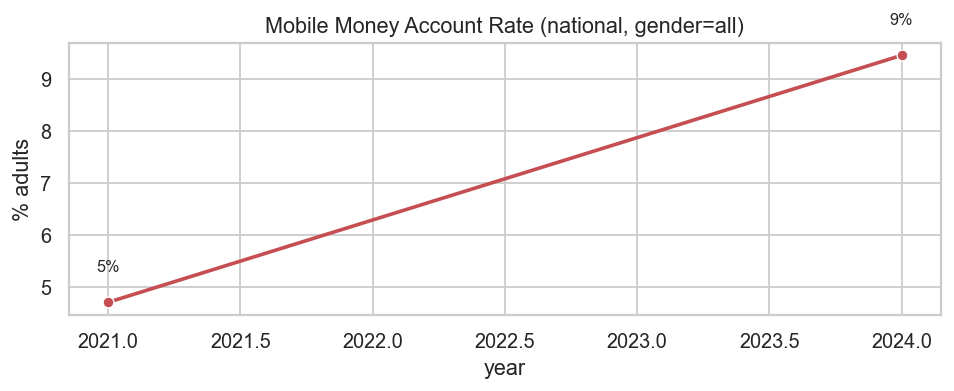

In [15]:

if len(mm) == 0:
    print("No ACC_MM_ACCOUNT observations found.")
else:
    plt.figure(figsize=(7.5,3.2))
    ax = sns.lineplot(data=mm, x="year", y="value_numeric", marker="o", linewidth=2, color="#C44E52")
    ax.set_title("Mobile Money Account Rate (national, gender=all)")
    ax.set_xlabel("year")
    ax.set_ylabel("% adults")
    for _, r in mm.iterrows():
        ax.text(r["year"], r["value_numeric"]+0.6, f"{r['value_numeric']:.0f}%", ha="center", fontsize=9)
    plt.tight_layout()
    plt.savefig(PLOT_DIR / "usage_mobile_money_account_rate.png")
    plt.show()



In [16]:

REG_ACT_CODES = ["usg_mpesa_users","usg_mpesa_active","usg_telebirr_users","usg_active_rate"]
snap = obs[obs["indicator_code"].isin(REG_ACT_CODES)].copy()
snap = snap.dropna(subset=["year","value_numeric"]).sort_values(["year","indicator_code"])
snap_tbl = snap[["indicator_code","indicator","observation_date","year","value_numeric","unit","source_name","confidence"]]
snap_tbl.to_csv(OUT_DIR / "usage_registered_active_snapshot_table.csv", index=False)
snap_tbl


,indicator_code,indicator,observation_date,year,value_numeric,unit,source_name,confidence
24,usg_active_rate,Mobile Money Activity Rate,2024-12-31,2024,66.0,%,Calculated,high
23,usg_mpesa_active,M-Pesa 90-Day Active Users,2024-12-31,2024,7100000.0,users,Safaricom Results,high
22,usg_mpesa_users,M-Pesa Registered Users,2024-12-31,2024,10800000.0,users,Safaricom Results,high
20,usg_telebirr_users,Telebirr Registered Users,2025-06-30,2025,54840000.0,users,Ethio Telecom Report,high


In [17]:

mp = snap[snap["indicator_code"].isin(["usg_mpesa_users","usg_mpesa_active"])].copy()
if len(mp) > 0:
    mp_w = mp.pivot_table(index=["observation_date","year"], columns="indicator_code", values="value_numeric", aggfunc="mean").reset_index()
    if "usg_mpesa_users" in mp_w.columns and "usg_mpesa_active" in mp_w.columns:
        mp_w["active_share"] = mp_w["usg_mpesa_active"] / mp_w["usg_mpesa_users"]
    mp_w.to_csv(OUT_DIR / "mpesa_registered_vs_active.csv", index=False)
    display(mp_w)



indicator_code,observation_date,year,usg_mpesa_active,usg_mpesa_users,active_share
0,2024-12-31,2024,7100000.0,10800000.0,0.657407


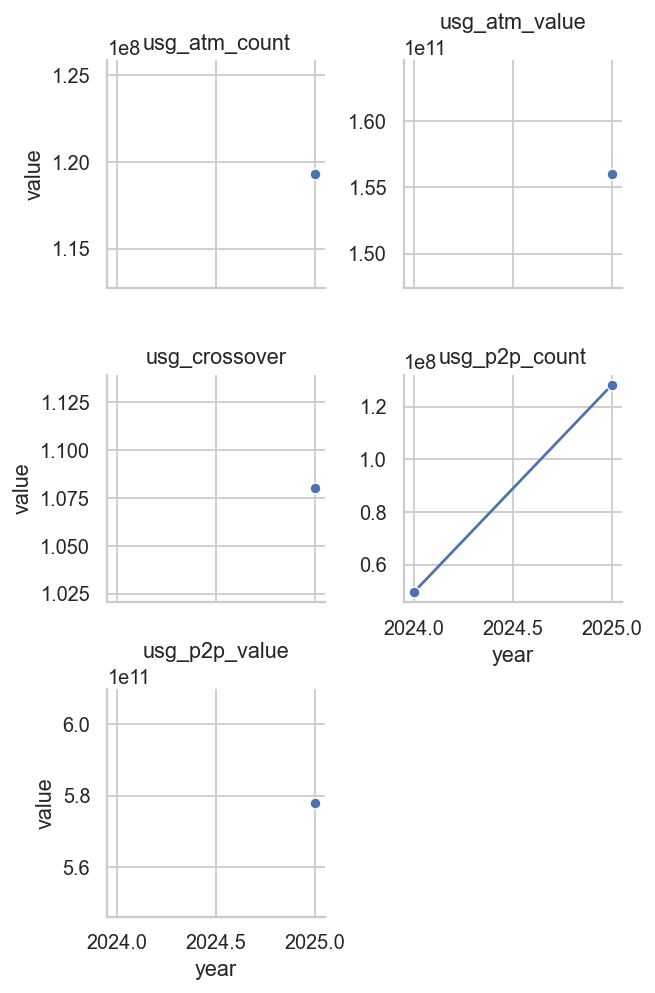

In [18]:

proxy_codes = ["usg_p2p_count","usg_p2p_value","usg_atm_count","usg_atm_value","usg_crossover"]
proxy = obs[obs["indicator_code"].isin(proxy_codes)].copy()
proxy = proxy.dropna(subset=["year","value_numeric"]).sort_values(["indicator_code","year"])
proxy[["indicator_code","indicator","year","value_numeric","unit"]].to_csv(OUT_DIR / "usage_proxies_table.csv", index=False)

if len(proxy) > 0:
    g = sns.FacetGrid(proxy, col="indicator_code", col_wrap=2, sharey=False, height=2.6)
    g.map_dataframe(sns.lineplot, x="year", y="value_numeric", marker="o")
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("year", "value")
    plt.tight_layout()
    plt.savefig(PLOT_DIR / "usage_proxies_small_multiples.png")
    plt.show()


## 4) Infrastructure and Enablers

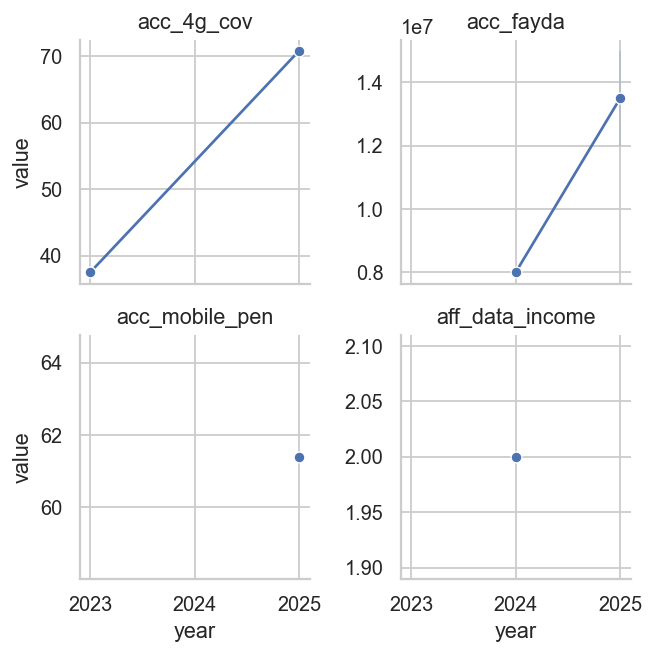

In [19]:

infra_codes = ["acc_4g_cov","acc_fayda","acc_mobile_pen","aff_data_income"]
infra = obs[obs["indicator_code"].isin(infra_codes)].copy()
infra = infra.dropna(subset=["year","value_numeric"]).sort_values(["indicator_code","year"])
infra[["indicator_code","indicator","year","value_numeric","unit"]].to_csv(OUT_DIR / "infrastructure_enablers_table.csv", index=False)

if len(infra) > 0:
    g = sns.FacetGrid(infra, col="indicator_code", col_wrap=2, sharey=False, height=2.6)
    g.map_dataframe(sns.lineplot, x="year", y="value_numeric", marker="o")
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("year", "value")
    plt.tight_layout()
    plt.savefig(PLOT_DIR / "infrastructure_enablers_small_multiples.png")
    plt.show()

## 5) Event Timeline and Overlays


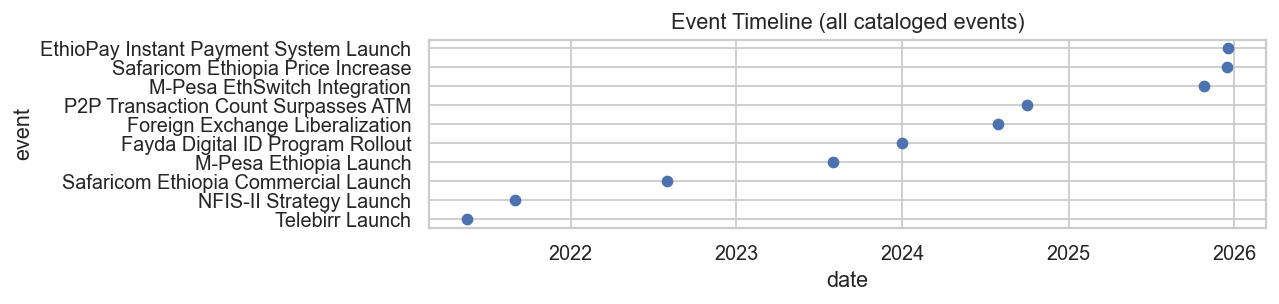

In [20]:

# --- Event Timeline (typed-friendly: no .get() into to_datetime; yticks uses list[str]) ---

events = df[df["record_type"] == "event"].copy()

# Parse optional period columns (only if present)
for c in ["period_start", "period_end"]:
    if c in events.columns:
        events[c] = pd.to_datetime(events[c], errors="coerce")

# Build event_date without using .get(...) (avoids Series | None typing)
if "observation_date" in events.columns:
    events["event_date"] = pd.to_datetime(events["observation_date"], errors="coerce")
else:
    events["event_date"] = pd.Series(pd.NaT, index=events.index, dtype="datetime64[ns]")

# Fallbacks if observation_date is missing/NaT
if "period_start" in events.columns:
    m = events["event_date"].isna()
    if bool(m.any()):
        events.loc[m, "event_date"] = pd.to_datetime(events.loc[m, "period_start"], errors="coerce")

if "period_end" in events.columns:
    m = events["event_date"].isna()
    if bool(m.any()):
        events.loc[m, "event_date"] = pd.to_datetime(events.loc[m, "period_end"], errors="coerce")

events = events.dropna(subset=["event_date"]).sort_values("event_date")

events_tbl = events[
    ["record_id", "indicator", "indicator_code", "event_date", "source_name", "source_url"]
].copy()
events_tbl.to_csv(OUT_DIR / "events_timeline_table.csv", index=False)

if len(events_tbl) > 0:
    plt.figure(figsize=(10, max(2.5, 0.25 * len(events_tbl))))
    y = np.arange(len(events_tbl))
    plt.scatter(events_tbl["event_date"], y, s=30)

    labels = events_tbl["indicator"].astype(str).tolist()  # Series -> list[str] for yticks typing
    plt.yticks(y, labels)

    plt.title("Event Timeline (all cataloged events)")
    plt.xlabel("date")
    plt.ylabel("event")
    plt.tight_layout()
    plt.savefig(PLOT_DIR / "events_timeline.png")
    plt.show()


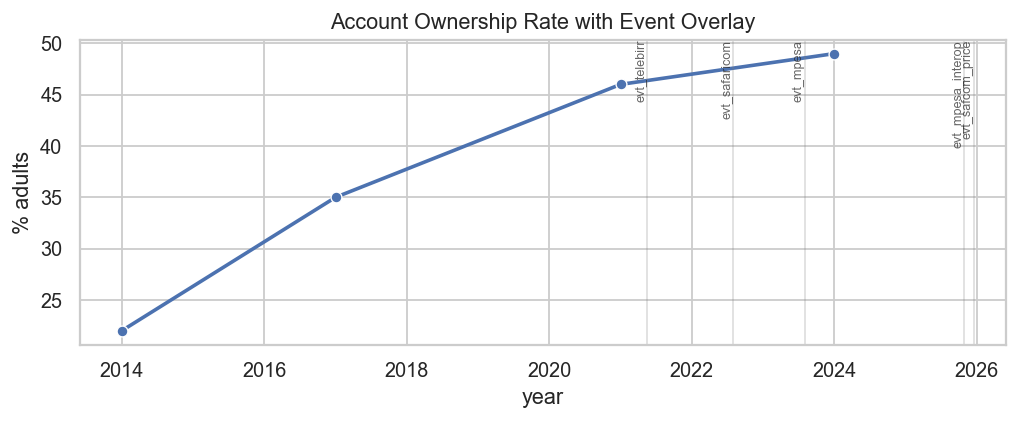

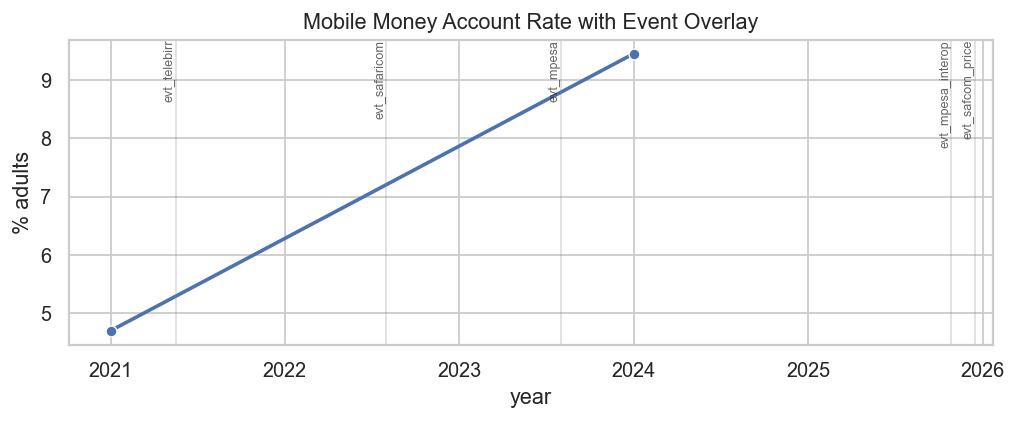

In [21]:
def _key_events(df_events: pd.DataFrame) -> pd.DataFrame:
    if len(df_events) == 0:
        return df_events
    mask = df_events["indicator"].astype(str).str.lower().str.contains("telebirr|safaricom|m-pesa|mpesa", na=False)
    return df_events[mask].copy()

key_events = _key_events(events_tbl)

def _event_x_year(edate: pd.Timestamp) -> float:
    return edate.year + (edate.dayofyear / 366.0)

def add_event_lines(ax, ev: pd.DataFrame, max_labels: int = 8):
    if ev is None or len(ev) == 0:
        return
    ev = ev.sort_values("event_date")
    for i, (_, r) in enumerate(ev.iterrows()):
        x = _event_x_year(r["event_date"])
        ax.axvline(x, color="grey", alpha=0.25, linewidth=1)
        if i < max_labels:
            ax.text(x, ax.get_ylim()[1], str(r["indicator_code"]), rotation=90,
                    va="top", ha="right", fontsize=7, alpha=0.7)

def plot_year_series_with_events(series: pd.DataFrame, title: str, ylab: str, fname: str):
    if len(series) == 0:
        print("No data for", title)
        return
    s = series.dropna(subset=["year","value_numeric"]).sort_values("year")
    plt.figure(figsize=(8,3.4))
    ax = plt.gca()
    sns.lineplot(data=s, x="year", y="value_numeric", marker="o", linewidth=2, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("year")
    ax.set_ylabel(ylab)
    add_event_lines(ax, key_events if len(key_events)>0 else events_tbl)
    plt.tight_layout()
    plt.savefig(PLOT_DIR / fname)
    plt.show()

plot_year_series_with_events(acc_all, "Account Ownership Rate with Event Overlay", "% adults", "overlay_access_account_ownership.png")
plot_year_series_with_events(mm, "Mobile Money Account Rate with Event Overlay", "% adults", "overlay_usage_mobile_money_rate.png")


## 6) Correlation Analysis + impact_link insights


In [22]:

obs_ng = obs[(obs["location"] == "national") & (obs["gender"] == "all")].copy()
wide = (
    obs_ng.dropna(subset=["year","value_numeric"])
         .pivot_table(index="year", columns="indicator_code", values="value_numeric", aggfunc="mean")
         .sort_index()
)
keep = wide.columns[wide.notna().sum(axis=0) >= 3]
wide_k = wide[keep]

if wide_k.shape[1] >= 2 and wide_k.shape[0] >= 3:
    corr = wide_k.corr()
    corr.to_csv(OUT_DIR / "correlation_matrix_national_gender_all.csv")
    plt.figure(figsize=(0.6*len(corr)+4, 0.6*len(corr)+3))
    ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_title("Correlation Matrix (national, gender=all; >=3 points)")
    plt.tight_layout()
    plt.savefig(PLOT_DIR / "correlation_matrix.png")
    plt.show()
else:
    print("Insufficient overlap for correlations under >=3-points rule.")



Insufficient overlap for correlations under >=3-points rule.


In [23]:

impact = df[df["record_type"] == "impact_link"].copy()
if len(impact) == 0:
    print("No impact_link records found.")
else:
    by_indicator = impact["indicator_code"].value_counts().rename_axis("indicator_code").reset_index(name="n_links")
    by_parent = impact["parent_id"].value_counts().rename_axis("parent_id").reset_index(name="n_links")
    by_indicator.to_csv(OUT_DIR / "impact_links_by_indicator.csv", index=False)
    by_parent.to_csv(OUT_DIR / "impact_links_by_parent_event.csv", index=False)
    by_indicator.head(20)


No impact_link records found.
